In [4]:
import pandas as pd
from sklearn.metrics import f1_score
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
# Import AdamW from torch.optim instead of transformers
from torch.optim import AdamW
from torch.nn.functional import softmax

ModuleNotFoundError: No module named 'pandas'

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Load Data
train_data = pd.read_csv('/content/train.csv')
validation_data = pd.read_csv('/content/validate.csv')
test_data = pd.read_csv('/content/test.csv')

# Define a function to encode labels
def encode_labels(label):
    if label == 'Neutral':
        return 0
    else:
        return 1

# Encode labels
train_data['label'] = train_data['label'].apply(encode_labels)
validation_data['label'] = validation_data['label'].apply(encode_labels)
test_data['label'] = test_data['label'].apply(encode_labels)

In [ ]:
# Define Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
      text = str(self.texts[idx])
      label = int(self.labels[idx])  # Convert label to integer

      inputs = self.tokenizer.encode_plus(
          text,
          None,
          add_special_tokens=True,
          max_length=self.max_len,
          padding='max_length',
          return_token_type_ids=True,
          truncation=True
      )

      return {
          'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
          'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
          'labels': torch.tensor(label, dtype=torch.long)
      }



# Model Training
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
max_len = 128  # You can adjust this value based on your text lengths
train_dataset = TextDataset(train_data['text'], train_data['label'], tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)
optimizer = AdamW(model.parameters(), lr=1e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
train_accuracies = []

for epoch in range(5):  # adjust as needed
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = epoch_loss / len(train_loader)
    accuracy = correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

# Validation
validation_dataset = TextDataset(validation_data['text'], validation_data['label'], tokenizer, max_len)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False)

model.eval()
pred_labels = []
true_labels = []
with torch.no_grad():
    for batch in validation_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)

        pred_labels.extend(predicted.cpu().detach().numpy())
        true_labels.extend(labels.cpu().detach().numpy())

validation_f1_score = f1_score(true_labels, pred_labels, average='micro')
print("Validation F1 Score: ", validation_f1_score)

# Evaluation
test_dataset = TextDataset(test_data['text'], test_data['label'], tokenizer, max_len)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

pred_labels = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)

        pred_labels.extend(predicted.cpu().detach().numpy())
        true_labels.extend(labels.cpu().detach().numpy())


f1_micro = f1_score(true_labels, pred_labels, average='micro')
f1_macro = f1_score(true_labels, pred_labels, average='macro')
f1_weighted = f1_score(true_labels, pred_labels, average='weighted')

print("F1 Score (Micro): ", f1_micro)
print("F1 Score (Macro): ", f1_macro)
print("F1 Score (Weighted): ", f1_weighted)

In [ ]:
# Define the path where you want to save the model
model_path = "xlm_roberta_model"

# Save the model
model.save_pretrained(model_path)

# Save the tokenizer as well
tokenizer.save_pretrained(model_path)


('xlm_roberta_model/tokenizer_config.json',
 'xlm_roberta_model/special_tokens_map.json',
 'xlm_roberta_model/sentencepiece.bpe.model',
 'xlm_roberta_model/added_tokens.json')

In [ ]:
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer
import torch

# Load the saved model and tokenizer
model_path = "xlm_roberta_model"
model = XLMRobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = XLMRobertaTokenizer.from_pretrained(model_path)

# Function to predict the label of an input text
def predict_label(input_text):
    # Tokenize the input text
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)

    # Perform inference
    logits = model(**inputs).logits
    predicted_class = torch.argmax(logits, dim=1).item()

    # Map predicted class index to label
    label_map = {0: 'Neutral', 1: 'Hateful'}
    predicted_label = label_map[predicted_class]

    return predicted_label

# Example usage
input_text = "তুমি ভালো ছেলে।"
predicted_label = predict_label(input_text)
print("Predicted Label:", predicted_label)


Predicted Label: Neutral


ROC AUC Score: 0.9105241554613746


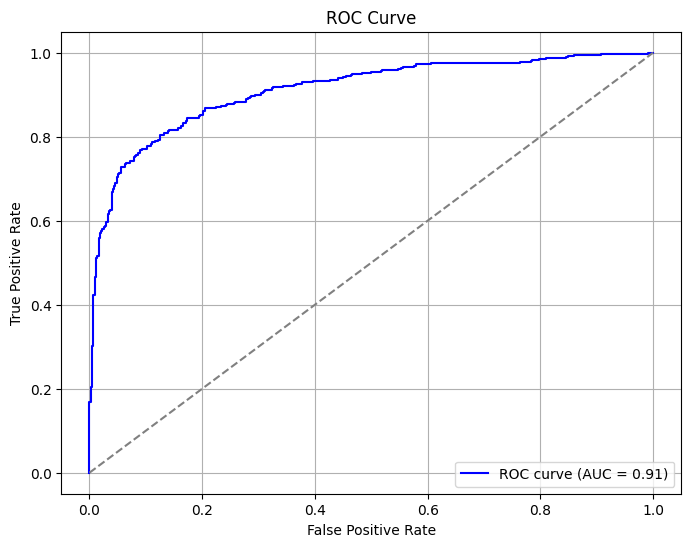

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Ensure you're using the correct device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the correct device

# Validation phase
model.eval()
pred_labels = []
true_labels = []
pred_probs = []  # To store predicted probabilities

with torch.no_grad():
    for batch in validation_loader:
        # Move the input tensors to the same device as the model
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass through the model
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predicted class labels
        _, predicted = torch.max(logits, 1)
        pred_labels.extend(predicted.cpu().detach().numpy())
        true_labels.extend(labels.cpu().detach().numpy())

        # Get predicted probabilities for the positive class (Hateful class)
        probs = torch.softmax(logits, dim=1)[:, 1]  # Get probabilities for class '1' (Hateful)
        pred_probs.extend(probs.cpu().detach().numpy())

# Calculate the ROC AUC score
roc_auc = roc_auc_score(true_labels, pred_probs)
print(f"ROC AUC Score: {roc_auc}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


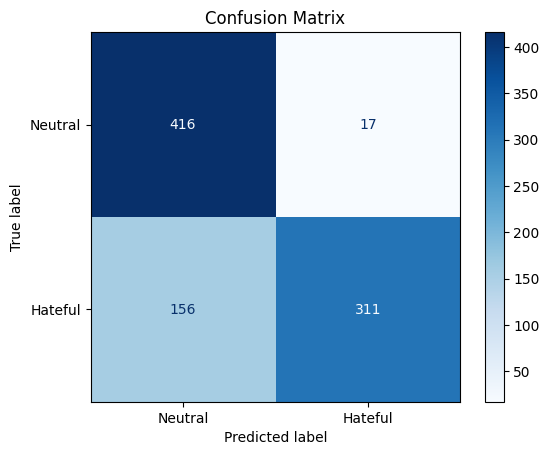

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neutral', 'Hateful'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

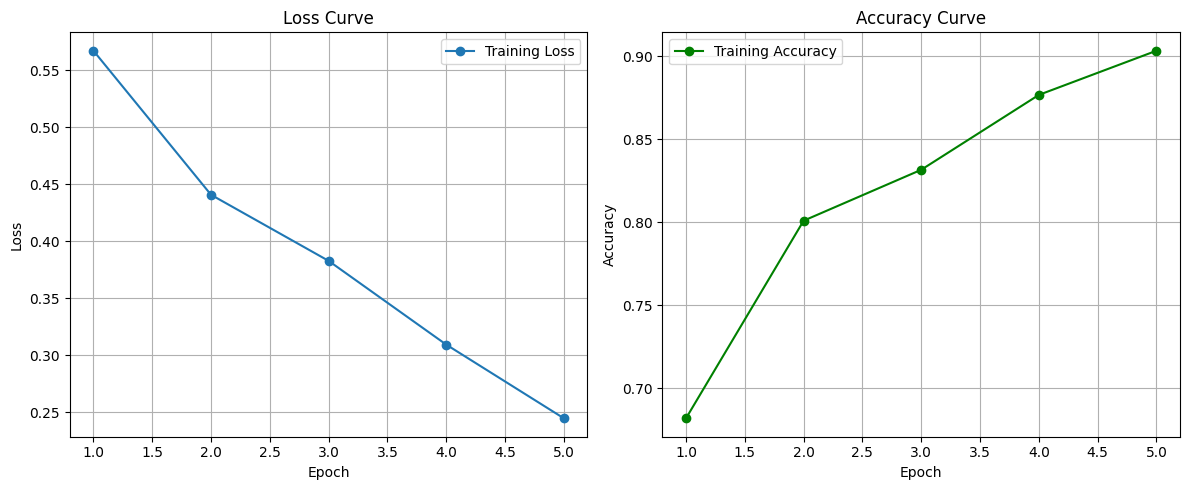

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', color='green', label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

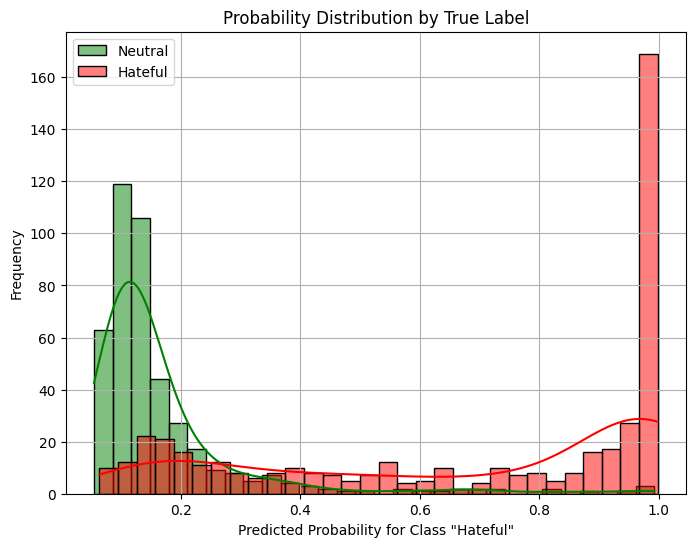

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pred_probs = np.array(pred_probs)
true_labels = np.array(true_labels)

plt.figure(figsize=(8, 6))
sns.histplot(pred_probs[true_labels == 0], color='green', label='Neutral', bins=30, kde=True)
sns.histplot(pred_probs[true_labels == 1], color='red', label='Hateful', bins=30, kde=True)
plt.xlabel('Predicted Probability for Class "Hateful"')
plt.ylabel('Frequency')
plt.title('Probability Distribution by True Label')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pip install streamlit

In [ ]:
pip install gradio

In [ ]:
import re
import gradio as gr
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer
import torch

# Load the saved model and tokenizer
model_path = "xlm_roberta_model"
model = XLMRobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = XLMRobertaTokenizer.from_pretrained(model_path)

# Function for data preprocessing
def preprocess_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Function to predict the label of an input text
def predict_label(input_text):
    # Preprocess the input text
    input_text = preprocess_text(input_text)

    # Tokenize and predict label
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
    logits = model(**inputs).logits
    predicted_class = torch.argmax(logits, dim=1).item()
    label_map = {0: 'Neutral', 1: 'Hateful'}
    predicted_label = label_map[predicted_class]
    return predicted_label

# Define the Gradio interface
gr.Interface(fn=predict_label, inputs="text", outputs="text", title="XLM-RoBERTa Text Classification").launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5e75d358a150669f96.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer
import torch

# Load the saved model and tokenizer
model_path = "xlm_roberta_model"
model = XLMRobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = XLMRobertaTokenizer.from_pretrained(model_path)

# Assuming you have your test data in test_data
test_dataset = TextDataset(test_data['text'], test_data['label'], tokenizer, max_len)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

from sklearn.metrics import accuracy_score

pred_labels = []
true_labels = []

# Move the model to the appropriate device before inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) # This line ensures the model is on the same device as the input tensors

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)

        pred_labels.extend(predicted.cpu().detach().numpy())
        true_labels.extend(labels.cpu().detach().numpy())

accuracy = accuracy_score(true_labels, pred_labels)
print("Accuracy: ", accuracy)

Accuracy:  0.79
